This notebook will create a preliminary dataset with features like records, fight details and fighter details. Then run a lasso reggression to determine the significant variables.

In [71]:
import pandas as pd
df = pd.read_csv('./raw/ufc_fight_results_date.txt')
df.columns

Index(['event', 'outcome', 'weightclass', 'method', 'round', 'time',
       'fight_id', 'fighter1', 'fighter2', 'date'],
      dtype='object')

In [72]:
df.head()

,event,outcome,weightclass,method,round,time,fight_id,fighter1,fighter2,date
0,UFC Fight Night: Dolidze vs. Imavov,0.0,mw,dec_maj,5,300,767ceb4a0cb43ade,Roman Dolidze,Nassourdine Imavov,2024-02-03
1,UFC Fight Night: Dolidze vs. Imavov,1.0,lw,dec_una,3,300,733e675fd7c0052a,Renato Moicano,Drew Dober,2024-02-03
2,UFC Fight Night: Dolidze vs. Imavov,1.0,ww,ko_tko,1,197,af6d56860ba4d259,Randy Brown,Muslim Salikhov,2024-02-03
3,UFC Fight Night: Dolidze vs. Imavov,0.0,wflw,dec_una,3,300,7b1882dc76786d77,Viviane Araujo,Natalia Silva,2024-02-03
4,UFC Fight Night: Dolidze vs. Imavov,0.0,ww,ko_tko,1,287,330d86bfaa4155fe,Gilbert Urbina,Charles Radtke,2024-02-03


In [73]:

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, Lasso
from sklearn.preprocessing import StandardScaler


In [74]:
#creating record for fighter 1

record = df.groupby(['fighter1', 'outcome'])['event'].count().reset_index()
record['outcome'] = np.where(
     record['outcome']== 0.0,
    'Win',
     np.where(
        record['outcome'] == 1.0, 'Loss', 'Tie'
     )
)
record_pivot = pd.pivot_table(data=record, values='event', index= 'fighter1',columns = 'outcome', aggfunc= 'sum')
record_pivot = record_pivot.fillna(0)

fighter_records = record_pivot.reset_index()
#fighter_records


#creating record for fighter 2
record2 = df.groupby(['fighter2', 'outcome'])['event'].count().reset_index()
#record2.head()
record2['outcome'] = np.where(
     record2['outcome']== 0.0,
    'Lose',
     np.where(
        record2['outcome'] == 1.0, 'Win', 'Tie'
     )
)
record_pivot2 = pd.pivot_table(data=record2, values='event', index= 'fighter2',columns = 'outcome', aggfunc= 'sum')
record_pivot2 = record_pivot2.fillna(0)

fighter_records2 = record_pivot2.reset_index()
#fighter_records2

In [75]:
#the record tables were exported to excel for easier manipulation, then saved as a new csv "fighter records"

#merging the records to the fight_results df

ufc_records = pd.read_csv('C:/Users/ddron/Documents/Divya GA Tech Course Files/Gatech Course Material Back up/MGT 6203/Project/code/Team-45/Feature Analysis/Project/raw/fighter_records.csv')
new = df.merge(ufc_records, left_on= 'fighter1', right_on = 'fighter', how='left')
new = new.merge(ufc_records, left_on= 'fighter2', right_on = 'fighter', how='left')
new= new.rename(columns={'W_x': 'W_f1', 'L_x': 'L_f1', 'W_y': 'W_f2', 'L_y': 'L_f2','fights_x': 'fights_f1', 'fights_y': 'fights_f2' })
new = new.drop(['fighter_x', 'fighter_y'], axis=1)

# Creating win proportion as a new variable because win/loss/total are highly correlated
new["win_proportion_f1"] = new['W_f1'] / new['fights_f1']
new["win_proportion_f1"] = new['win_proportion_f1'].replace([float('inf'), float('-inf')], 0)

new["win_proportion_f2"] = new['W_f2'] / new['fights_f2']
new["win_proportion_f2"] = new['win_proportion_f2'].replace([float('inf'), float('-inf')], 0)

new.drop(columns=["W_f1","W_f2","L_f1","L_f2"],inplace=True)




In [76]:
new.columns

Index(['event', 'outcome', 'weightclass', 'method', 'round', 'time',
       'fight_id', 'fighter1', 'fighter2', 'date', 'fights_f1', 'fights_f2',
       'win_proportion_f1', 'win_proportion_f2'],
      dtype='object')

In [77]:
#mapping the weight class to numeric
# wclasses = new['weightclass'].unique()
# wclass_dummies = {}
# a=0

# for i in wclasses:
#   wclass_dummies[i] = a
#   a+=1

# wclass_dummies


# #stripping the name columns
# new2 = new.replace(wclass_dummies.keys(),wclass_dummies.values())
df_obj = new.select_dtypes('object')
new[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())

#new2


In [78]:
#adding fighter attributes and merging into main dataframe

fighter_attributes = pd.read_csv('./raw/ufc_fighter_tott_clean.txt')
new3 = pd.merge(new, fighter_attributes, left_on='fighter1', right_on='fighter', how='left')
new3 = pd.merge(new3, fighter_attributes, left_on='fighter2', right_on='fighter', how='inner')
#new3.head()


In [79]:
#Creating new variables for difference in heights, reach, stance_orthodox and stance_southpaw as they are very correlated
new3["height_diff"]=new3["height_x"]-new3["height_y"]
new3["reach_diff"]=new3["reach_x"]-new3["reach_y"]
new3.drop(columns=["height_x","height_y","reach_x","reach_y"],inplace=True)

In [80]:
#exporting this to be used in the cleaned_features notebook

new3.to_csv('./raw/clean_df_temporary.csv', index=False)

In [81]:
#Creating a age column at the time of the fight

new3['age_x'] = pd.to_datetime(new3['date']) - pd.to_datetime(new3['dob_x'])
new3['age_y'] = pd.to_datetime(new3['date']) - pd.to_datetime(new3['dob_y'])
#new3

In [82]:
#Looks like the date of births in the ufc_fighter_tott_clean data is mostly blanks. I'll remove the age columns for now for the purposes of 
# feature analysis, but would be interested to add the back in later


new3.isna().sum()

event                   0
outcome                 0
weightclass             0
method                  0
round                   0
time                    0
fight_id                0
fighter1                0
fighter2                0
date                    0
fights_f1              44
fights_f2              42
win_proportion_f1      44
win_proportion_f2      42
fighter_x              15
stance_x              148
dob_x                5245
fighter_id_x           15
fighter_y               0
stance_y              199
dob_y                5235
fighter_id_y            0
height_diff           148
reach_diff            659
age_x                5245
age_y                5235
dtype: int64

In [83]:
#dropping features that won't be important to the model, and dropping null values

cleaned_features1 = new3.drop(columns= (['age_x', 'age_y', 'dob_x', 'dob_y', 'date', 'event', 'fight_id', 'fighter1', 'fighter2', 'method', 'fighter_id_x', 'fighter_id_y', 'fighter_x', 'fighter_y']))
cleaned_features1.dropna(inplace=True)

In [84]:
#creating dummy variables for all categorical caolumns

cleaned_features1['round'] = cleaned_features1['round'].astype('category')
pd.set_option('display.max_columns', None)
cleaned_features1 = pd.get_dummies(cleaned_features1, drop_first = True, dtype = int)
#Interaction terms produced constants
# cleaned_features1["stance_x_Orthodox_Southpaw"]=cleaned_features1["stance_x_Orthodox"]*cleaned_features1["stance_x_Southpaw"]
# cleaned_features1["stance_y_Orthodox_Southpaw"]=cleaned_features1["stance_y_Orthodox"]*cleaned_features1["stance_y_Southpaw"]
cleaned_features1.drop(columns=["stance_x_Southpaw","stance_y_Southpaw"],inplace=True)

In [85]:
cleaned_features1

,outcome,time,fights_f1,fights_f2,win_proportion_f1,win_proportion_f2,height_diff,reach_diff,weightclass_flw,weightclass_ftw,weightclass_hw,weightclass_lhw,weightclass_lw,weightclass_mw,weightclass_wbw,weightclass_wflw,weightclass_wsw,weightclass_ww,round_2,round_3,round_4,round_5,stance_x_Orthodox,stance_x_Switch,stance_y_Orthodox,stance_y_Switch
0,0.0,300,5.0,5.0,0.200000,0.4,-1.0,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0
1,1.0,300,6.0,5.0,0.166667,0.4,-2.0,1.0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0
2,0.0,292,5.0,5.0,0.400000,0.4,-1.0,-1.0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0
3,1.0,300,7.0,5.0,0.571429,0.4,-3.0,2.0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0
4,0.0,300,1.0,5.0,1.000000,0.4,-2.0,0.0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5715,1.0,114,8.0,1.0,0.625000,1.0,-2.0,-3.0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0
5716,1.0,143,2.0,1.0,0.500000,1.0,-3.0,-3.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
5717,1.0,300,4.0,1.0,0.500000,1.0,-4.0,-3.0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0
5720,1.0,300,13.0,1.0,0.461538,1.0,-1.0,-1.0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0


Fitting 5 folds for each of 7 candidates, totalling 35 fits
Classification Report for Test Set:
              precision    recall  f1-score   support

         0.0       0.82      0.77      0.79       652
         1.0       0.83      0.87      0.85       842

    accuracy                           0.83      1494
   macro avg       0.82      0.82      0.82      1494
weighted avg       0.82      0.83      0.82      1494



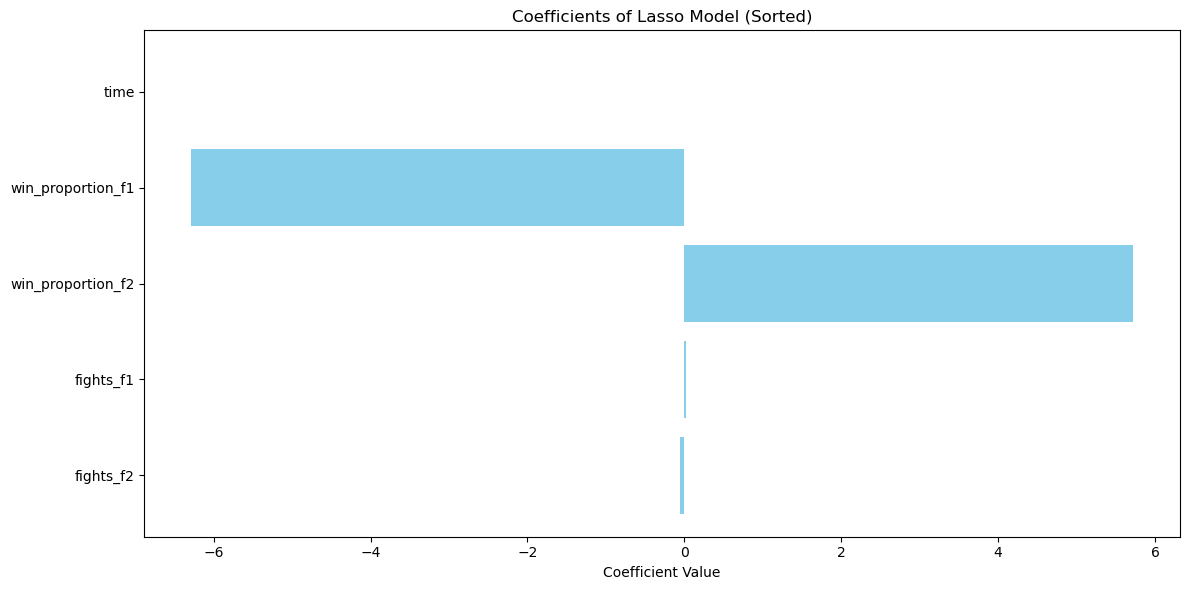

Test Accuracy: 0.8253012048192772


In [86]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

def find_best_lasso_model(df):
    # Create Logistic Regression model with L1 regularization (Lasso)
    y= df['outcome'] #Outcome = 1 means figher 1 won, Outcome = 2 means fighter 2 won
    X = df.loc[:, df.columns != 'outcome']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)
    
    lasso_model = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)

    # Define parameter grid for alpha
    param_grid = {
        'C': np.logspace(-3, 3, 7)  # C is the inverse of alpha
    }

    # Create GridSearchCV object
    grid_search = GridSearchCV(estimator=lasso_model, param_grid=param_grid, cv=5, scoring='accuracy',
                               verbose=1, n_jobs=-1)

    # Fit GridSearchCV object to the training data
    grid_search.fit(X_train, y_train)

    # Get best alpha
    best_alpha = grid_search.best_params_['C']

    # Create and return best Lasso model with the best alpha
    best_lasso_model = LogisticRegression(penalty='l1', solver='liblinear', C=best_alpha, random_state=42)
    
    # Train the best model on the full training set
    best_lasso_model.fit(X_train, y_train)
    
    feature_names=X.columns
    # Get feature importance for Logistic Regression
    lasso_coefficients = best_lasso_model.coef_[0]
    lasso_feature_names =feature_names

    # Filter coefficients and feature names where coefficient is greater than zero
    selected_coefficients = [coef for coef, name in zip(lasso_coefficients, lasso_feature_names) if coef > 0]
    selected_feature_names = [name for coef, name in zip(lasso_coefficients, lasso_feature_names) if coef > 0]
    
    X_train_selected = X_train[selected_feature_names]
    X_test_selected = X_test[selected_feature_names]
    
    # Make predictions on test set
    y_test_pred = best_lasso_model.predict(X_test)
    
    # Calculate accuracy for test set
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    # Print classification report for test set
    print("Classification Report for Test Set:")
    print(classification_report(y_test, y_test_pred))

    #Display sorted features
    # Sort the coefficients and feature names based on coefficients
    sorted_indices = np.argsort(selected_coefficients)[::-1]
    sorted_coefficients = [lasso_coefficients[i] for i in sorted_indices]
    sorted_feature_names = [lasso_feature_names[i] for i in sorted_indices]
    
    # Plot the coefficients
    # Plot feature importance
    plt.figure(figsize=(12, 6))
    plt.barh(sorted_feature_names, sorted_coefficients, color='skyblue')
    plt.xlabel('Coefficient Value')
    plt.title('Coefficients of Lasso Model (Sorted)')
    
    plt.tight_layout()
    plt.show()

    cleaned_features_selected=df[selected_feature_names+["outcome"]]
    return test_accuracy, cleaned_features_selected

# Example usage
test_accuracy, cleaned_features_selected = find_best_lasso_model(cleaned_features1)
print("Test Accuracy:", test_accuracy)

In [87]:
#exporting this dataset 
cleaned_features1.to_csv('./clean/cleaned_features.csv')

In [88]:
cleaned_features_selected.to_csv('./clean/cleaned_features_Lasso.csv')